# Elastic-Inspired Hybrid Anomaly Detection Pipeline

In [22]:
# === Improt ===
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.cluster import DBSCAN
from statsmodels.tsa.seasonal import STL
from pyod.models.ecod import ECOD
import torch
import torch.nn as nn
import torch.optim as optim
from datetime import datetime

# === CONFIG ===

In [23]:

train_csv_path = "../test_csv/normal_2.csv"
test_csv_path = "../test_csv/motor_temp_high.csv"
window_size = 30
epochs = 50
batch_size = 64
contamination = 0.05


# === LOAD & PREPARE DATA ===

In [ ]:
state_batch_24h = [
    "00:00 off",
    "01:30 idle",
    "02:00 run",
    "08:00 off",
    "09:00 idle",
    "09:30 run",
    "09:45 idle",
    "10:00 run",
    "17:00 idle",
    "17:30 run",
    "23:59 run"
]

def apply_state_batch(df, state_batch, default_state="off"):
    transitions = []
    for entry in state_batch:
        time_str, state = entry.rsplit(" ", 1)
        time_obj = datetime.strptime(time_str, "%H:%M").time() 
        transitions.append((time_obj, state.lower()))

    df = df.copy()
    df["state"] = default_state
    df["state"] = df["state"].astype("object")  # or "string"
    times = df.index.time

    current_state = default_state
    next_idx = 0

    for i, t in enumerate(times):
        while next_idx < len(transitions) and t >= transitions[next_idx][0]:
            current_state = transitions[next_idx][1]
            next_idx += 1
        df.iat[i, df.columns.get_loc("state")] = current_state

    return df


def prepare_data(file_path, state_batch):
    df = pd.read_csv(file_path, parse_dates=["timestamp"])
    pivot_df = df.pivot(index="timestamp", columns="sensor", values="feature_0").interpolate().dropna()
    pivot_df = apply_state_batch(pivot_df, state_batch)

    # Encode state to numerical
    pivot_df["state_encoded"] = pivot_df["state"].astype("category").cat.codes

    return pivot_df

def create_sequences(data, window_size):
    X, timestamps = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        timestamps.append(i + window_size - 1)
    return np.array(X), timestamps



In [ ]:
# Step 1: Load and prepare raw data with state_batch
train_df = prepare_data(train_csv_path, state_batch_24h)
test_df = prepare_data(test_csv_path, state_batch_24h)

# Step 2: Separate sensor features and state_encoded
sensor_cols = [col for col in train_df.columns if col not in ["state", "state_encoded"]]

# Split data into sensors + state
train_sensor = train_df[sensor_cols]
test_sensor = test_df[sensor_cols]

# Convert state_encoded to integers explicitly 
train_state = train_df["state_encoded"].astype(int).values.reshape(-1, 1)
test_state = test_df["state_encoded"].astype(int).values.reshape(-1, 1)
print(test_state[:, -1].dtype)
# Step 3: Scale sensor features only
scaler = RobustScaler()
train_scaled_sensor = scaler.fit_transform(train_sensor)
test_scaled_sensor = scaler.transform(test_sensor)

# Step 4: Concatenate scaled sensors + raw state (last column = state)
train_scaled = np.concatenate([train_scaled_sensor, train_state], axis=1)
test_scaled = np.concatenate([test_scaled_sensor, test_state], axis=1)

print("Train scaled shape:", train_scaled.shape)
print("state dtype:", train_scaled[:, -1].dtype)

# Step 5: Create sequences (LSTM input format)
X_train, train_times = create_sequences(train_scaled, window_size)
X_test, test_times = create_sequences(test_scaled, window_size)

print(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")
print("State min:", X_train[:, :, -1].min())
print("State max:", X_train[:, :, -1].max())
print("State dtype:", X_train[:, :, -1].dtype)

[[1]
 [1]
 [1]
 ...
 [2]
 [2]
 [2]]
Train scaled shape: (43170, 5)
state dtype: float64
X_train shape: (43140, 30, 5), X_test shape: (1409, 30, 5)
State min: 0.0
State max: 2.0
State dtype: float64


# === STAGE 1: UNSUPERVISED ENSEMBLE ON TRAINING DATA ===

In [26]:
# Flatten each window (sequence) into 1D vector
flat_train = X_train.reshape(X_train.shape[0], -1)

# -- STL on a representative sensor or state-aware signal
# You can use the primary signal, e.g., sensor_0 or state_encoded as a trend
stl_series = train_df["state_encoded"] if "state_encoded" in train_df.columns else train_df.mean(axis=1)
stl = STL(stl_series, period=24)  # you may tune this period for your sampling rate
resid = np.abs(stl.fit().resid)
resid = (resid - resid.min()) / (resid.max() - resid.min())  # normalize
resid_scores = resid[-len(flat_train):]

# -- Isolation Forest
iso = IsolationForest(contamination=contamination, random_state=42)
iso_scores = -iso.fit_predict(flat_train)

# -- One-Class SVM
svm = OneClassSVM(nu=contamination)
svm_scores = -svm.fit_predict(flat_train)

# -- DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_scores = (dbscan.fit_predict(flat_train) == -1).astype(int)

# -- ECOD
ecod = ECOD(contamination=contamination)
ecod_scores = ecod.fit_predict(flat_train)

# -- Combine ensemble scores (you can tune the weights)
unsup_score = (
    0.25 * resid_scores +
    0.25 * iso_scores +
    0.20 * svm_scores +
    0.15 * dbscan_scores +
    0.15 * ecod_scores
)

# -- Thresholding
threshold_unsup = np.percentile(unsup_score, 100 * (1 - contamination))
pseudo_labels = (unsup_score > threshold_unsup).astype(int)


g:\Conda\envs\python3.12\Lib\site-packages\sklearn\utils\deprecation.py:95: FutureWarning: Function fit_predict is deprecated
  warnings.warn(msg, category=FutureWarning)


# === PLOT PSEUDO LABELS ON TRAINING DATA ===

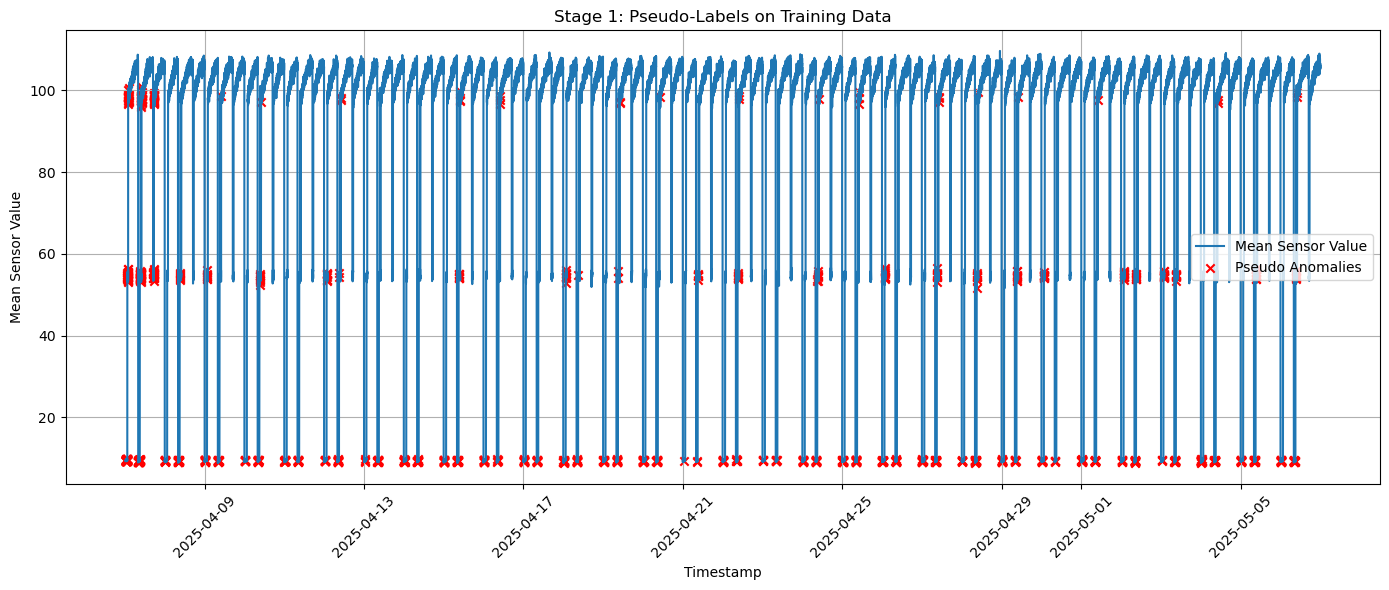

In [27]:
# === PLOT PSEUDO LABELS ON TRAINING DATA ===
sensor_columns = [col for col in train_df.columns if col not in ["state", "state_encoded"]]
mean_values = train_df[sensor_columns].mean(axis=1).values
plot_series = mean_values[train_times]      # values that match the windowed sequences

# Convert train_times (ints) into actual timestamps
train_timestamps = train_df.index[train_times]

# Now plot
plt.figure(figsize=(14, 6))
plt.plot(train_timestamps, plot_series, label="Mean Sensor Value")

# Overlay pseudo anomalies
anomaly_times = train_timestamps[pseudo_labels == 1]
anomaly_values = plot_series[pseudo_labels == 1]

plt.scatter(anomaly_times, anomaly_values, color='red', marker='x', label='Pseudo Anomalies')
plt.title("Stage 1: Pseudo-Labels on Training Data")
plt.xlabel("Timestamp")
plt.ylabel("Mean Sensor Value")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# === STAGE 2: LSTM-AE with ATTENTION ===

In [28]:
# # -- Set device
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # -- Weight boosting: pseudo-labeled anomalies get higher weight
# train_weights = np.ones(len(X_train))
# train_weights[pseudo_labels == 1] = 3.0  # or another multiplier

# # -- Wrap into DataLoader
# train_dataset = torch.utils.data.TensorDataset(
#     torch.tensor(X_train, dtype=torch.float32),
#     torch.tensor(train_weights, dtype=torch.float32)
# )
# train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# # -- Attention layer (already provided)
# class AttentionLayer(nn.Module):
#     def __init__(self, input_dim):
#         super().__init__()
#         self.attn = nn.Linear(input_dim, 1)
#         self.softmax = nn.Softmax(dim=1)
    
#     def forward(self, x):
#         weights = self.softmax(self.attn(x))  # shape: (batch, seq_len, 1)
#         context = torch.sum(weights * x, dim=1, keepdim=True)
#         return context.repeat(1, x.shape[1], 1)

# # -- LSTM Autoencoder with attention
# class LSTMAE(nn.Module):
#     def __init__(self, n_features):
#         super().__init__()
#         self.lstm1 = nn.LSTM(n_features, 64, batch_first=True)
#         self.dropout1 = nn.Dropout(0.2)
#         self.attn = AttentionLayer(64)
#         self.lstm2 = nn.LSTM(64, 32, batch_first=True)
#         self.dropout2 = nn.Dropout(0.2)
#         self.out = nn.Linear(32, n_features)

#     def forward(self, x):
#         x, _ = self.lstm1(x)
#         x = self.dropout1(x)
#         x = self.attn(x)
#         x, _ = self.lstm2(x)
#         x = self.dropout2(x)
#         return self.out(x)

# # -- Initialize model
# model = LSTMAE(X_train.shape[2]).to(device)
# optimizer = optim.Adam(model.parameters(), lr=0.001)
# loss_fn = nn.MSELoss(reduction='none')  # we'll reduce manually with weights

# # -- Training loop
# print("Training LSTM Autoencoder...")
# model.train()
# for epoch in range(epochs):
#     total_loss = 0
#     for xb, sw in train_loader:
#         xb = xb.to(device)
#         sw = sw.to(device)

#         optimizer.zero_grad()
#         recon = model(xb)

#         # Compute reconstruction loss per sequence
#         loss_per_sample = loss_fn(recon, xb).mean(dim=(1, 2)) * sw
#         loss = loss_per_sample.mean()

#         loss.backward()
#         optimizer.step()
#         total_loss += loss.item()

#     print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss / len(train_loader):.4f}")

In [53]:
# -- Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -- Prepare sample weights (pseudo-labeled anomalies get higher weight)
train_weights = np.ones(len(X_train))
train_weights[pseudo_labels == 1] = 3.0

# -- Separate sensor vs state features
sensor_dim = X_train.shape[2] - 1  # all but the last feature are sensors
state_vocab_size = int(X_train[:, :, -1].max()) + 1  # categorical range of state

# -- Wrap into DataLoader (convert to tensor, cast state as int)
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_train_tensor[:, :, -1] = X_train_tensor[:, :, -1].int() # required for embedding
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, torch.tensor(train_weights, dtype=torch.float32))
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# -- Attention layer
class AttentionLayer(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.attn = nn.Linear(input_dim, 1)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        weights = self.softmax(self.attn(x))  # (batch, seq_len, 1)
        context = torch.sum(weights * x, dim=1, keepdim=True)
        return context.repeat(1, x.shape[1], 1)

# -- LSTM Autoencoder with embedded state input
class LSTMAEWithState(nn.Module):
    def __init__(self, sensor_dim, state_vocab_size, state_embed_dim=4):
        super().__init__()
        self.sensor_dim = sensor_dim
        self.state_embed = nn.Embedding(state_vocab_size, state_embed_dim)

        self.lstm1 = nn.LSTM(sensor_dim + state_embed_dim, 64, batch_first=True)
        self.dropout1 = nn.Dropout(0.2)
        self.attn = AttentionLayer(64)
        self.lstm2 = nn.LSTM(64, 32, batch_first=True)
        self.dropout2 = nn.Dropout(0.2)
        self.out = nn.Linear(32, sensor_dim)  # only reconstruct sensor values

    def forward(self, x):
        sensor_input = x[:, :, :self.sensor_dim]           # (batch, seq_len, sensor_dim)
        state_input = x[:, :, self.sensor_dim].long()      # (batch, seq_len)
        state_embed = self.state_embed(state_input)        # (batch, seq_len, embed_dim)

        x_cat = torch.cat([sensor_input, state_embed], dim=2)  # concat along feature dim
        x, _ = self.lstm1(x_cat)
        x = self.dropout1(x)
        x = self.attn(x)
        x, _ = self.lstm2(x)
        x = self.dropout2(x)
        return self.out(x)
print("State min:", X_train[:, :, -1].min())
print("State max:", X_train[:, :, -1].max())
print("Expected vocab size:", state_vocab_size)
# -- Initialize model
model = LSTMAEWithState(sensor_dim, state_vocab_size).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss(reduction='none')  # manual reduction with weights

# -- Training loop
print("Training LSTM Autoencoder with State Embedding...")
model.train()
for epoch in range(epochs):
    total_loss = 0
    for xb, sw in train_loader:
        xb = xb.to(device)
        sw = sw.to(device)

        optimizer.zero_grad()
        recon = model(xb)

        # Only compute loss on sensor part (not state)
        sensor_target = xb[:, :, :sensor_dim]
        loss_per_sample = loss_fn(recon, sensor_target).mean(dim=(1, 2)) * sw
        loss = loss_per_sample.mean()

        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss / len(train_loader):.4f}")


State min: 0.0
State max: 2.0
Expected vocab size: 3


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


# === EVALUATION ===

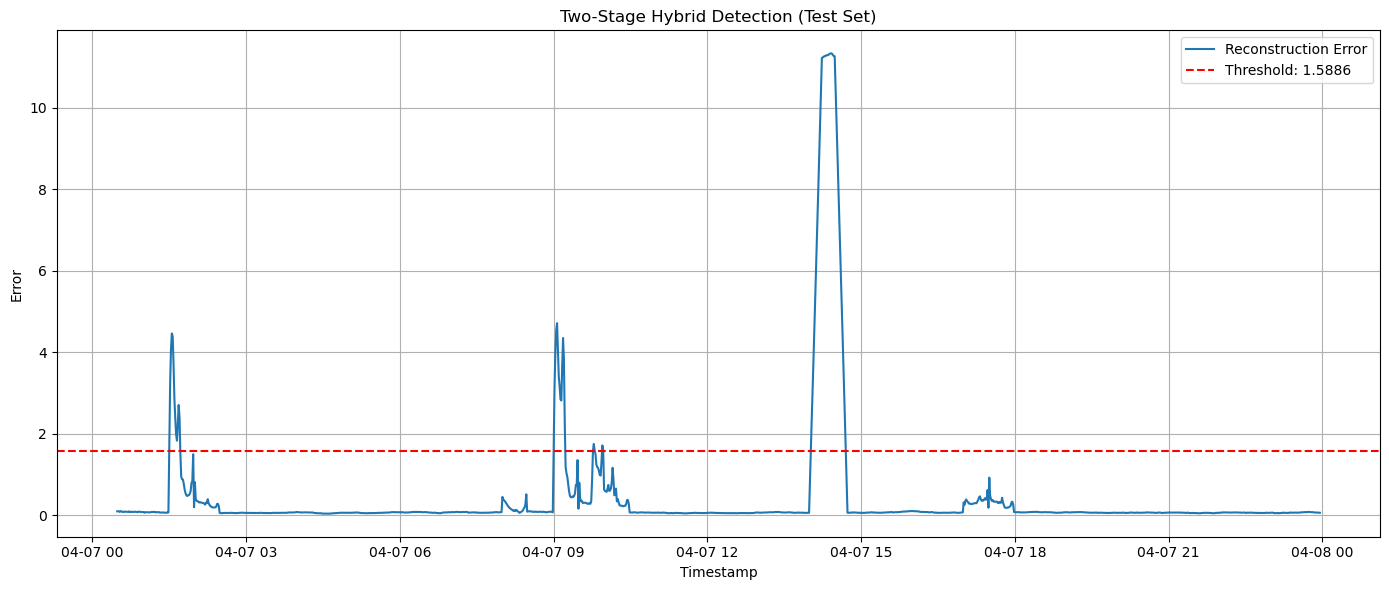

In [ ]:
model.eval()
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
with torch.no_grad():
    recon = model(X_test_tensor).cpu().numpy()
recon_error = np.mean((X_test - recon) ** 2, axis=(1,2))

threshold = np.percentile(recon_error, 100 * (1 - contamination))
preds = (recon_error > threshold).astype(int)

# === PLOT ===
plt.figure(figsize=(14, 6))
plt.plot(test_df.index[test_times], recon_error, label="Reconstruction Error")
plt.axhline(threshold, color='red', linestyle='--', label=f"Threshold: {threshold:.4f}")
plt.title("Two-Stage Hybrid Detection (Test Set)")
plt.xlabel("Timestamp")
plt.ylabel("Error")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
